# Hedging against S&P500

In [1]:
from datetime import datetime
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV

#### Factor Models
Factor models are a way of explaining the portfolio returns via a linear combination of the returns of other assets, indicators or other factors. The general form of a factor model is

$$ Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n $$

The portfolio beta to another asset or indicator is simply the $\beta$ in the above model. As a basic example, we will construct a portfolio that consists of only two companies: Apple [AAPL] (100 shares), and Ford [F] (500 shares).

## Step 1: Obtain historic price data
Portfolio data

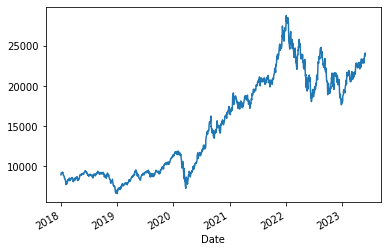

In [2]:
apple: pd.Series = yf.download('AAPL','2018-01-01',datetime.today(), progress=False)['Adj Close']
ford: pd.Series = yf.download('F','2018-01-01',datetime.today(), progress=False)['Adj Close']
    
portfolio: pd.Series = 100*apple + 500*ford

portfolio.plot();

Index

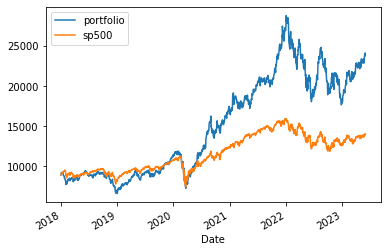

In [3]:
sp500: pd.Series = yf.download('^GSPC','2018-01-01',datetime.today(), progress=False)['Close']
scaling_parameter: float = portfolio[0] / sp500[0]
rescaled_index = sp500 * scaling_parameter
    
data = pd.DataFrame({'portfolio': portfolio, 'sp500': rescaled_index})
data.plot();

## Step 2: Transform historic prices to returns

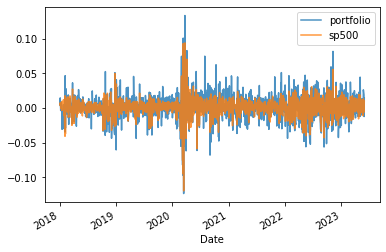

In [4]:
data.loc[:, 'portfolio'] = data.portfolio.pct_change()
data.loc[:, 'sp500'] = data.sp500.pct_change()
data.dropna(inplace=True);
data.plot(alpha=0.8);

## Step 3: Perform a linear regression
The linear regression should be done with the portfolio returns as the target variable and the oil price returns as the explanatory variable. The intercept should be included in the regression. Make use of the [linear model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from Sklearn.

In [5]:
regression = ElasticNetCV(fit_intercept=True)
y = data['portfolio']
X = data['sp500'].values.reshape(-1, 1)
regression.fit(
    X = X,
    y = y);

In [6]:
print('Portfolio beta: ', round(regression.coef_[0], 4))
print('Intercept: ', round(regression.intercept_, 4))

# Getting the R squared is more complicated
# -> SKlearn not made for statistical analysis
yhat = regression.predict(X)
SS_Residual = sum((y-yhat)**2)       
SS_Total = sum((y-np.mean(y))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
print('R-squared: ', round(r_squared, 4))

Portfolio beta:  1.1565
Intercept:  0.0004
R-squared:  0.7276


##### Extra: scatter plot with regression line

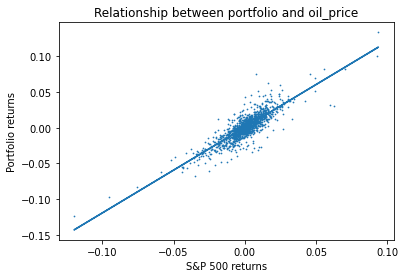

In [7]:
plt.scatter(data['sp500'], data['portfolio'], s=0.5)
m, b = np.polyfit(data['sp500'], data['portfolio'], 1)
plt.plot(data['sp500'], m*data['sp500']+b);
plt.title('Relationship between portfolio and oil_price')
plt.xlabel('S&P 500 returns')
plt.ylabel('Portfolio returns');

## Step 4: Hedging
More generally, this beta gets at the concept of how much risk exposure you take on by holding an asset. If an asset has a high beta exposure to the S&P 500, then while it will do very well while the market is rising, it will do very poorly when the market falls. A high beta corresponds to high speculative risk.

Many institutional investors value strategies that have negligible beta exposure to as many factors as possible. What this means is that all of the returns in a strategy lie in the $\alpha$ portion of the model, and are independent of other factors. This is highly desirable, as it means that the strategy is agnostic to market conditions. It will make money equally well in a crash as it will during a bull market.

If we determine that our portfolio's returns are dependent on the market via this relation

$$ Y_{portfolio} = \alpha + \beta X_{SP500} $$

then we can take out a short position of $-\beta$ times the market value of the portfolio in the S&P 500.

The problem here is that the estimated beta is not necessarily constant over time. As such, the amount we short the S&P 500 may not perfectly hedge the portfolio which can make it difficult to reduce the beta to zero.

#### Hedged portfolio

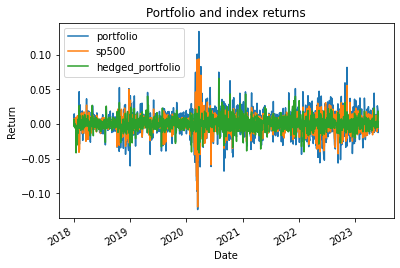

In [8]:
data.loc[:, 'hedged_portfolio'] = data.portfolio - data.sp500 * regression.coef_[0]
data.plot();
plt.title('Portfolio and index returns')
plt.ylabel('Return');

Compare the returns and volatility of the original portfolio:

In [9]:
print('Return portfolio:        ', round(data.portfolio.mean(), 5))
print('Return hedged portfolio: ', round(data.hedged_portfolio.mean(), 5))
print('\nVolatility portfolio:        ', round(data.portfolio.std(), 5))
print('Volatility hedged portfolio: ', round(data.hedged_portfolio.std(), 5))

Return portfolio:         0.0009
Return hedged portfolio:  0.00042

Volatility portfolio:         0.01891
Volatility hedged portfolio:  0.00987


#### Stability of estimated hedge over time
As mentioned above, the beta value does not remain constant as time progresses. In order to assess the stability of the beta estimate over time, we compute the value for beta in a rolling time window. **Assume that the beta is always estimated based on the previous 100 trading days.**

In [ ]:
!pip install numpy_ext
# Compact version using numpy_ext
from numpy_ext import rolling_apply

def get_beta(portfolio: np.array, sp500: np.array):
    regression = HuberRegressor(fit_intercept=True)
    y = portfolio
    X = sp500.reshape(-1, 1)
    regression.fit(
        X = X,
        y = y);
    return regression.coef_[0]

data.loc[:, 'beta'] = rolling_apply(get_beta, 100, data.portfolio.values, data.sp500.values)
data.beta.plot();
plt.title('Stability of beta hedge over time');
plt.ylabel('Bèta');

  Using cached numpy_ext-0.9.8-py3-none-any.whl (7.2 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0


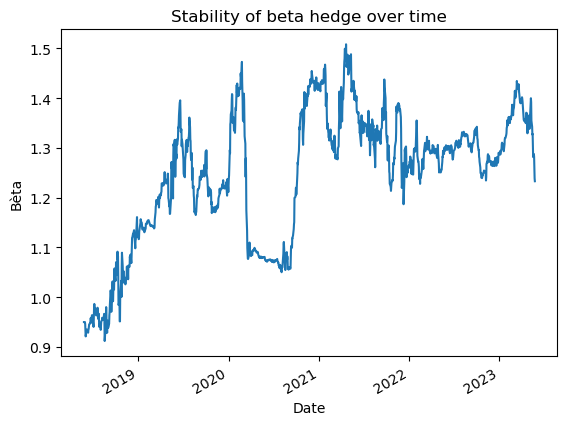

In [11]:
# Using for loops (tip: if you are using a for loop combined with pandas, there is probably a more efficient method)
days: int = 100
regression = HuberRegressor(fit_intercept=True)
for index, row in data.iterrows():
    row_number: int = data.index.get_loc(index)
    if row_number - days >= 0:
        subset: pd.DataFrame = data.iloc[row_number-days:row_number]
        y = subset.portfolio.values
        X = subset.sp500.values.reshape(-1, 1)
        regression.fit(
            X = X,
            y = y);
        row['beta'] = regression.coef_[0]
data.beta.plot();
plt.title('Stability of beta hedge over time');
plt.ylabel('Bèta');

#### Getting the returns of the time-variant beta hedged portfolio

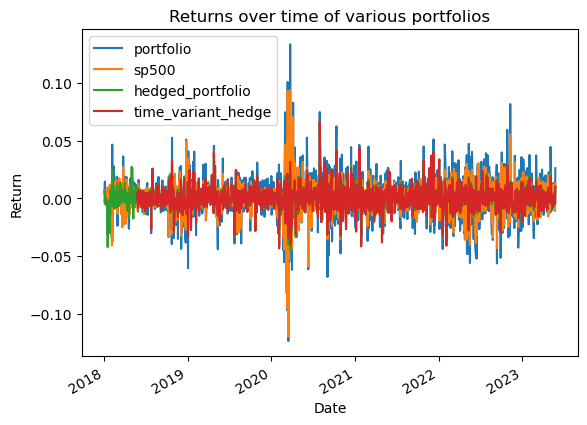

In [12]:
data.loc[:, 'time_variant_hedge'] = data.portfolio - data.sp500*data.beta
data[['portfolio', 'sp500', 'hedged_portfolio', 'time_variant_hedge']].plot()
plt.title('Returns over time of various portfolios')
plt.ylabel('Return');

#### Calculating the final beta of the time-variant beta hedged portfolio

In [13]:
data.dropna(inplace=True)
y = data.time_variant_hedge.values
X = data.sp500.values.reshape(-1, 1)
regression.fit(
    X = X,
    y = y);

In [14]:
print('Portfolio beta: ', round(regression.coef_[0], 4))
print('Intercept: ', round(regression.intercept_, 4))
yhat = regression.predict(X)
SS_Residual = sum((y-yhat)**2)       
SS_Total = sum((y-np.mean(y))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
print('R-squared: ', round(r_squared, 4))

Portfolio beta:  -0.0178
Intercept:  0.0004
R-squared:  0.0001
